Welcome to assignment 1.                                                       

We are using pathology images for our first assignment please download data from this link https://drive.google.com/drive/folders/10dUOzcPR-PQwfFYcHk5gsLjIjSorQ32Q?usp=sharing



### Task 1: Feature Generation (15%)
Use and run the following code (a deep network) to generate features from a set of training images. For this assignment, you do not need to know how the deep network is working here to extract features.
This code extracts the features of image T4.tif (in the T folder of dataset). Modify the code so that it iterates over all images of the dataset and extracts their features.
Allocate 10% of the data for validation.

Insert your code here for Task 1





In [112]:
import torch
import torchvision.transforms as transforms
from torchvision.models import densenet121
from torch.autograd import Variable
from PIL import Image
import os
import numpy as np

# Load pre-trained DenseNet model
model = densenet121(pretrained=True)

# Remove the classification layer (last fully connected layer)
model = torch.nn.Sequential(*list(model.children())[:-1])

# Add a global average pooling layer
model.add_module('global_avg_pool', torch.nn.AdaptiveAvgPool2d(1))

# Set the model to evaluation mode
model.eval()

# Define the image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Path to the "train" folder
train_folder = "train"

train_labels = []
train_feature_vectors = []


# Iterate over all the folders and files in the "train" folder
for root, dirs, files in os.walk(train_folder):
    for file in files:
        # Get the image path
        image_path = os.path.join(root, file)
        
        # Load an image 
        image = Image.open(image_path)

        # get class label from root
        label = root.split("\\")[1]
        train_labels.append(float((ord(label) - ord('A')))) # convert chars into numbers where A -> 0

        # Preprocess the image
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

        # Wrap the input tensor in a Variable
        input_var = Variable(input_batch)

        # Forward pass through the model
        features = model(input_var)

        # Extract the feature tensor
        feature_vector = features.squeeze().detach().numpy()
        train_feature_vectors.append(feature_vector)

train_feature_vectors = np.array(train_feature_vectors)
train_labels = np.array(train_labels)


c:\Users\lusal\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lusal\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Task 1 Cont'd
Validation Data

In [113]:
import os
# Path to the "validate" folder
validate_folder = "validate"

# Initialize empty lists for the validation data
validate_feature_vectors = []
validate_labels = []

# Iterate over all the folders and files in the "validate" folder
for root, dirs, files in os.walk(validate_folder):
    for file in files:
        # Get the image path
        image_path = os.path.join(root, file)
        
        # Load an image 
        image = Image.open(image_path)


        # Preprocess the image
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

        # Wrap the input tensor in a Variable
        input_var = Variable(input_batch)

        # Forward pass through the model
        features = model(input_var)

        # Extract the feature tensor
        feature_vector = features.squeeze().detach().numpy()

        # Append the feature vector and label to the validation lists
        validate_feature_vectors.append(feature_vector)
        
        # get class label from root
        label = root.split("\\")[1]
        validate_labels.append(float((ord(label) - ord('A')))) # convert chars into numbers where A -> 0

validate_feature_vectors = np.array(validate_feature_vectors)
validate_labels = np.array(validate_labels)

# Task 2: High Bias Classification Method (5%)
Choose a classification method and let is have a high bias.
Train it on the generated features and discuss why it is underfitting.

Insert your code here for Task 2




Accuracy: -0.008241711009026487


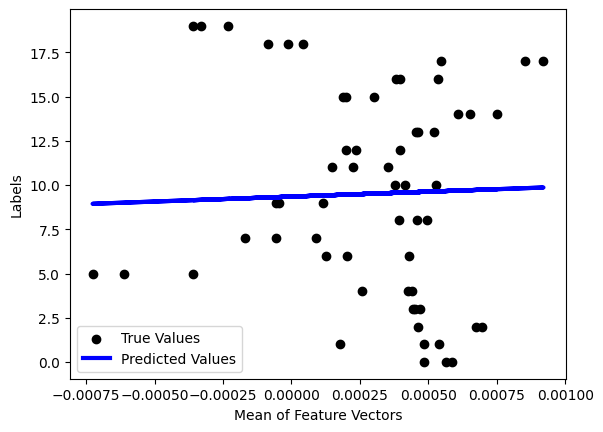

In [114]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Split the data into training and validation sets and only select first feature for high bias
biased_X_train = train_feature_vectors[:, :1]
y_train = train_labels
biased_X_val = validate_feature_vectors[:, :1]
y_val = validate_labels

clf = LinearRegression()
clf.fit(biased_X_train, y_train)
pred_values = clf.predict(biased_X_val) 

# Evaluate the model based on the validation data
accuracy = clf.score(biased_X_val, y_val)
print("Accuracy:", accuracy)

plt.scatter(biased_X_val, y_val, color="black", label="True Values")
plt.plot(biased_X_val, pred_values, color="blue", linewidth=3, label="Predicted Values")
plt.xlabel('Mean of Feature Vectors')
plt.ylabel('Labels')
plt.legend()
plt.show()

### Task 2 Discussion

To induce a high level of bias in the classification model, only the first feature is utilized for both the training and validation datasets. By solely relying on the first feature, the model lacks sufficient information to adequately represent the dataset. This limited information hampers the model's ability to discern underlying patterns and relationships, resulting in poor performance, as evidenced by the low accuracy.

Subsequently, linear regression is employed as the classification method, assuming a linear relationship between the input features and the target variables. However, such an assumption is susceptible to underfitting if the relationship is non-linear. In such cases, the model fails to capture the underlying, more complex patterns in the data. This limitation is evident in the graph above, where the model's predictions follow a linear trajectory that poorly represents the dataset.

In summary, the model's performance is hindered by the restricted information provided to it and the oversimplification inherent in the chosen classification method. As a consequence, the model struggles to establish an effective relationship between the input and output, primarily due to underfitting.

# Task 3: High Variance Classification Method (5%)
Use the chosen classification method and let it have a high variance.
Train it on the generated features and discuss why it is overfitting.

Insert your code here for Task 3




Accuracy: 0.8739184111285809


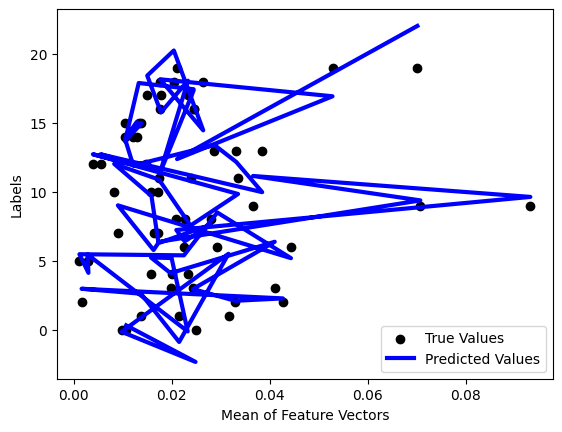

In [115]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features up to a higher degree (to increase variance)
poly = PolynomialFeatures(degree=2)

X_train_expanded = poly.fit_transform(train_feature_vectors)
X_val_expanded = poly.transform(validate_feature_vectors)

clf = LinearRegression()
clf.fit(X_train_expanded, y_train)
train_pred = clf.predict(X_val_expanded)

# Evaluate the model on the validation data
accuracy = clf.score(X_val_expanded, y_val)
X_val_expanded = np.mean(X_val_expanded, axis=1).reshape(-1, 1)

print("Accuracy:", accuracy)

plt.scatter(X_val_expanded, y_val, color="black", label="True Values")
plt.plot(X_val_expanded, train_pred, color="blue", linewidth=3, label="Predicted Values")
plt.xlabel('Mean of Feature Vectors')
plt.ylabel('Labels')
plt.legend()
plt.show()

### Task 3 Discussion

To introduce a high level of variance in the classification model, the feature space is expanded, thereby increasing the model's capacity. This heightened capacity allows the model to closely fit the training data, including noise and outliers, resulting in higher variance and overfitting.

Subsequently, linear regression is applied to the model with polynomial features, further increasing its complexity. This increased complexity leads to the capturing of undesired patterns, such as noise, causing the model to overfit.

In summary, the model is trained on a significantly expanded feature space, causing it to essentially memorize the training data rather than learn the underlying patterns. This overfitting is apparent in the graph above, where the predictions closely track the training data and are likely to have low accuracy on new data.

# Task 4: Balanced Classification Method (15%)
Use the chosen classification method and let it balance the bias and variance.
Train it on the generated features, possibly adjusting parameters.
Discuss insights into achieving balance.

Insert your code here for Task 4




Accuracy: 0.9061444725381702


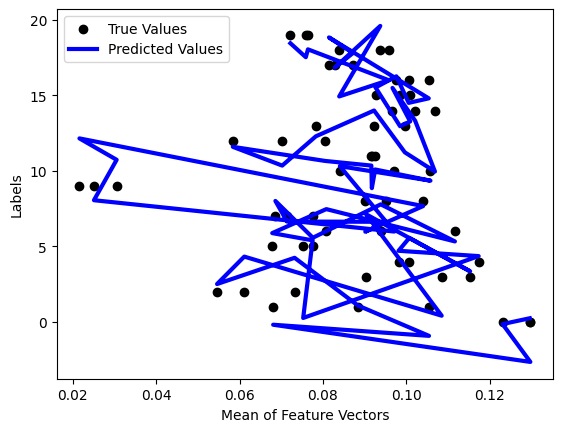

In [116]:
y_train = train_labels
y_val = validate_labels
balanced_val = validate_feature_vectors[:, :250]
balanced_train = train_feature_vectors[:, :250]

clf = LinearRegression()

clf.fit(balanced_train, y_train)
pred_values = clf.predict(balanced_val) 

# Evaluate the model on the validation data
accuracy = clf.score(balanced_val, y_val)
print("Accuracy:", accuracy)

balanced_val = np.mean(balanced_val, axis=1).reshape(-1, 1)

plt.scatter(balanced_val, y_val, color="black", label="True Values")
plt.plot(balanced_val, pred_values, color="blue", linewidth=3, label="Predicted Values")
plt.xlabel('Mean of Feature Vectors')
plt.ylabel('Labels')
plt.legend()
plt.show()

### Task 4 Discussion

Linear regression being a simple model tends have more bias inertly. The bias is somewhat controlled by limiting the number of features which can help prevent the model from capturing complex relationships in the data that may not be representative or generalize well.

First the higher variance was addressed by changing the complexity of the feature space in an attempt to lower the variance of the model by limiting potential overfit of the data. The feature space was kept at linear to reduce variance.

The code attempts to strike a balance by using a simple linear regression model (low complexity) and evaluating its performance on a separate validation set (to assess generalization).

# Task 5: K-Means Clustering (20%)
Apply K-Means clustering on the generated features.
Test with available labels and report accuracy.
Experiment with automated K and compare with manually set 20 clusters.

Insert your code here for Task 5




### Libraries and Elbow Method

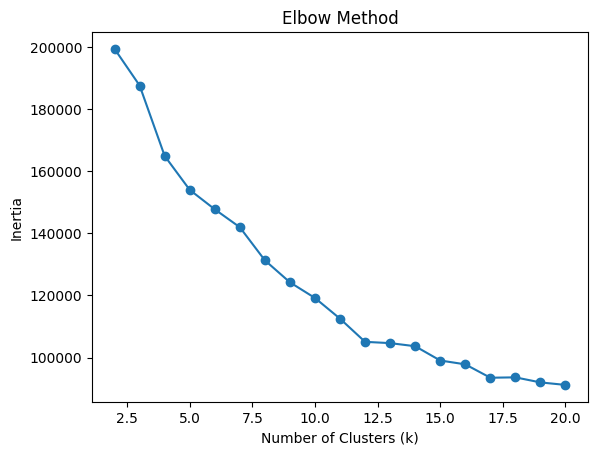

In [117]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

os.environ['OMP_NUM_THREADS'] = '3'

k_values_auto = range(2, 21)
inertia_values = []

for k in k_values_auto:
    kmeans_auto = KMeans(n_clusters=k)
    kmeans_auto.fit(train_feature_vectors)

    # Get the inertia value (sum of squared distances to the nearest centroid) for the model
    inertia = kmeans_auto.inertia_
    inertia_values.append(inertia)

plt.plot(k_values_auto, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

### Kmeans Classification

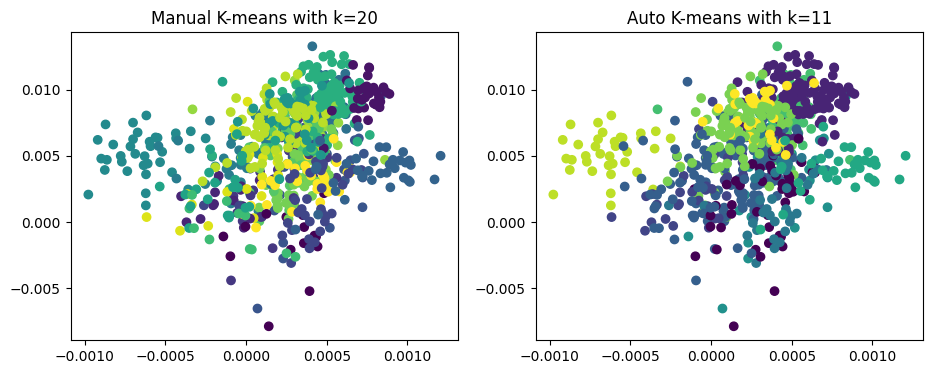

Manual Accuracy: 0.004166666666666667
Auto Accuracy: 0.04722222222222222


In [118]:
## Manual select k ---------------------------------------------------------------
k_manual = 20

kmeans_manual = KMeans(n_clusters=k_manual, random_state=111)
kmeans_manual.fit(train_feature_vectors)
train_kmeansManualCluster_labels = kmeans_manual.labels_

## Auto select k ---------------------------------------------------------------
# Select the elbow point from plot in code below as the best value for k
k_auto = 11

kmeans_auto = KMeans(n_clusters=k_auto, random_state=111)
kmeans_auto.fit(train_feature_vectors)
train_kmeansAutoCluster_labels = kmeans_auto.labels_

# Plot Manual Case
plt.figure(2,figsize = (11,4))
ax1 = plt.subplot(1, 2, 1)
plt.scatter(train_feature_vectors[:, 0], train_feature_vectors[:, 1], c=train_kmeansManualCluster_labels, cmap='viridis')
# plt.scatter(kmeans_manual.cluster_centers_[:, 0], kmeans_manual.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.title('Manual K-means with k=20')

# Plot the clusters on the auto training data
ax2 = plt.subplot(1, 2, 2)
plt.scatter(train_feature_vectors[:, 0], train_feature_vectors[:, 1], c=train_kmeansAutoCluster_labels, cmap='viridis')
# plt.scatter(kmeans_auto.cluster_centers_[:, 0], kmeans_auto.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.title(f'Auto K-means with k={k_auto}')
plt.show()

accuracy_manual = accuracy_score(train_kmeansManualCluster_labels, train_labels)
accuracy_auto = accuracy_score(train_kmeansAutoCluster_labels, train_labels)

print("Manual Accuracy:", accuracy_manual)
print("Auto Accuracy:", accuracy_auto)


### Task 5 Discussion
The provided code implements K-means clustering on generated features. Initially, it employs the elbow method to determine the optimal number of clusters (k) by plotting the inertia values against the number of clusters. The elbow point in the plot signifies the most suitable value for k.

Subsequently, the code conducts K-means clustering with both manually selected (k=20) and automatically determined (k=11) values of k, chosen using the elbow method. The resulting clusters are visualized using scatter plots.

Upon evaluating the clustering results, the code computes the accuracies by comparing the cluster labels with the actual labels. It is observed that the manual K-means clustering achieves an accuracy of 0.41%, while the automatically determined K-means clustering achieves an accuracy of 4.7%. Although both accuracies are relatively low, the "auto" method demonstrates approximately 10 times better performance.

The subpar performance is likely attributed to significant overlap among the data points within the clusters, making it challenging for the clustering algorithm to distinguish distinct groups effectively. K-Means clustering does not inherently aim to predict class labels. Instead, it identifies patterns or clusters in the data based on similarity between feature vectors. Therefore, the notion of accuracy is not directly applicable in the same way as in supervised learning tasks.


# Task 6: Additional Clustering Algorithm (10%)
Choose another clustering algorithm and apply it on the features.
Test accuracy with available labels.

Insert your code here for Task 6




### Libraries and K-Distance Graph

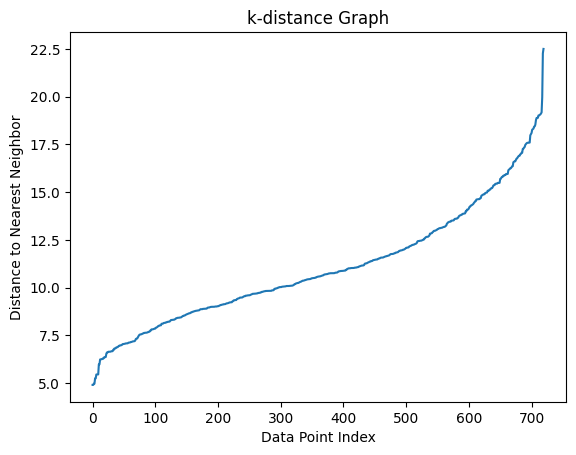

In [119]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# # Create a NearestNeighbors object to determine eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(train_feature_vectors)
distances, indices = nbrs.kneighbors(train_feature_vectors)

# Sort the distances to the kth nearest neighbor
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.xlabel('Data Point Index')
plt.ylabel('Distance to Nearest Neighbor')
plt.title('k-distance Graph')
plt.plot(distances)
plt.show()

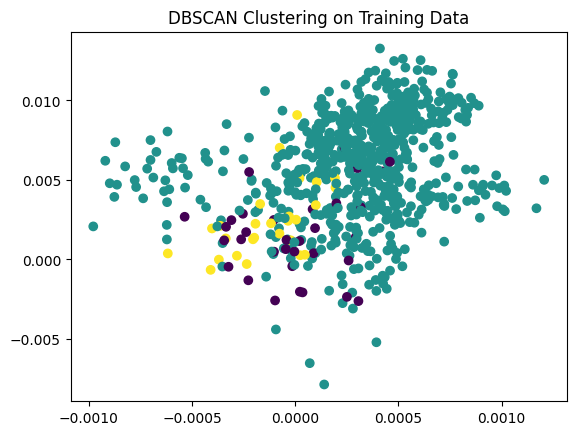

Silhouette Score: 0.18039356


In [120]:
dbscan = DBSCAN(eps=18, min_samples=4)
dbscan.fit(train_feature_vectors)
train_dbscan_labels = dbscan.labels_

plt.scatter(train_feature_vectors[:, 0], train_feature_vectors[:, 1], c=train_dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clustering on Training Data')
plt.show()

silhouette_avg = silhouette_score(train_feature_vectors, train_dbscan_labels)
print("Silhouette Score:", silhouette_avg)

### Task 6 Discussion
The DBSCAN algorithm was applied to the feature vectors in order to perform clustering. The algorithm uses a density-based approach to group similar data points together.

The K-Distance graph is used to determine an optimal epsilon (eps) value of 15 for the algorithm.

The resulting clusters are visualized on the training data using a scatter plot. Each data point is assigned a cluster label, which is represented by a different color in the plot.

The silhouette score is calculated to evaluate the quality of the clustering results. The silhouette score measures how well each data point fits into its assigned cluster, with values ranging from -1 to 1. A higher silhouette score indicates better clustering. 
Here we have a score of 0.18 which is considered a weak clustering score.
The weak score is most likely due to the lots of overlap of the points



# Task 7: PCA for Classification Improvement (20%)
Apply PCA on the features and then feed them to the best classification method in the above tasks.
Assess if PCA improves outcomes and discuss the results.

Insert your code here for Task 7




Total variance captured with 160 components: 0.9646424809470773
Accuracy with PCA: 0.7985072922826407


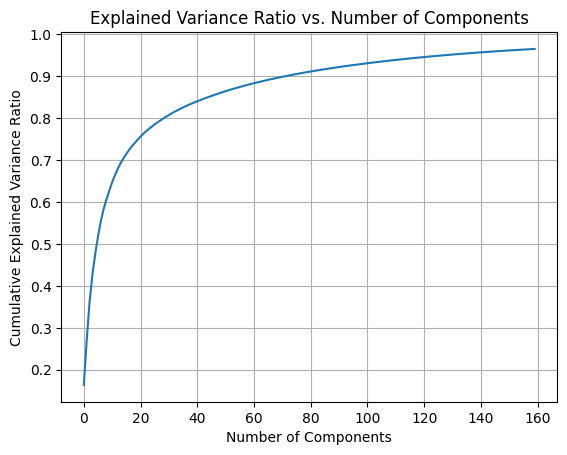

In [121]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

n_components = 160
pca = PCA(n_components=n_components)
pca.fit(train_feature_vectors)

train_feature_vectors_pca = pca.transform(train_feature_vectors)
validate_feature_vectors_pca = pca.transform(validate_feature_vectors)

y_train = train_labels
y_val = validate_labels
balanced_train = train_feature_vectors_pca
balanced_val = validate_feature_vectors_pca

print(f"Total variance captured with {n_components} components: {sum(pca.explained_variance_ratio_)}")

clf = LinearRegression()

clf.fit(balanced_train, y_train)
pred_values = clf.predict(balanced_val) 

accuracy_with_pca = clf.score(balanced_val, y_val)
print("Accuracy with PCA:", accuracy_with_pca)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

### Task 7 Discussion

The PCA did not improve the results for the linear regression classification model. It can be seen that by using 100 components we are effectively capturing over 95% of variance contained in the dataset, which is a common target for PCA.

This may be because PCA involves a trade-off between dimensionality reduction and information retention. In our case, perhaps by reducing the dimensionality of the data, it might have resulted in a loss of important information necessary for accurate classification. PCA also assumes a linear relationship between variables, which may not be true for our experiment. PCA is linear and the data may contain a high degree of non-linearity, making the results worse. 

# Task 8: Visualization and Analysis (10%)
Plot the features in a lower dimension using dimensionality reduction techniques.
Analyze the visual representation, identifying patterns or insights.

Insert your code here for Task 8

Total variance captured with 20 components: 0.748579990118742
Accuracy with PCA: 0.715393607617093


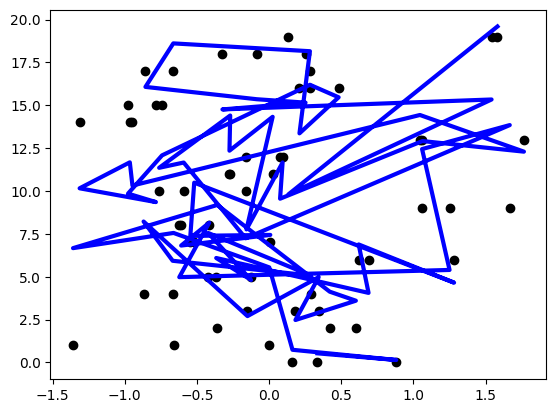

In [122]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

n_components = 20
pca = PCA(n_components=n_components)
pca.fit(train_feature_vectors)

train_feature_vectors_pca = pca.transform(train_feature_vectors)
validate_feature_vectors_pca = pca.transform(validate_feature_vectors)

y_train = train_labels
y_val = validate_labels
balanced_train = train_feature_vectors_pca
balanced_val = validate_feature_vectors_pca

print(f"Total variance captured with {n_components} components: {sum(pca.explained_variance_ratio_)}")

clf = LinearRegression()
clf.fit(balanced_train, y_train)
pred_values = clf.predict(balanced_val) 

accuracy_with_pca = clf.score(balanced_val, y_val)
print("Accuracy with PCA:", accuracy_with_pca)

balanced_val = np.mean(balanced_val, axis=1).reshape(-1, 1)

plt.scatter(balanced_val, y_val, color="black")
plt.plot(balanced_val, pred_values, color="blue", linewidth=3)

plt.show()

### Task 8 Discussion

It can be seen in the plot that using features that have been reduced in dimension via PCA, the model is not as accurate at classifying the data.